# Analysis of Leios simulations at tag `leios-2025w10`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
})

## Receipt of messages

### Read results

In [2]:
receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w10", collection="receipts")$find(), stringsAsFactors=TRUE)
receipts %>% summary

   simulator             sent           received         elapsed      
 haskell:12399135   Min.   :  0.00   Min.   :  0.00   Min.   : 0.000  
                    1st Qu.: 41.13   1st Qu.: 43.39   1st Qu.: 1.119  
                    Median : 80.00   Median : 81.54   Median : 1.739  
                    Mean   : 77.60   Mean   : 79.93   Mean   : 2.336  
                    3rd Qu.:115.13   3rd Qu.:118.33   3rd Qu.: 2.516  
                    Max.   :150.00   Max.   :150.00   Max.   :67.392  
                                     NA's   :94       NA's   :94      
    producer          recipient        kind               item         
 node-99:12240472   node-90:  125469   EB:   33000   23-0   :    9400  
 node-98:  139140   node-31:  125431   IB:11120152   33-0   :    9400  
 node-95:    7973   node-1 :  125420   RB:   53959   35-0   :    9400  
 node-93:    2608   node-64:  125408   VT: 1192024   47-0   :    9400  
 node-97:    2315   node-67:  125386                 52-0   :    9400  


In [3]:
fwrite(receipts, "results/receipts.csv")

### Scenarios present in dataset

In [4]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
haskell,100,default,10871503
haskell,100,with-cpu,762304
haskell,100,without-cpu,765328


### Delay due to CPU usage

In [5]:
receiptsCpu <-
receipts[
    `simulator` == "haskell" & 
    `label` %in% c("with-cpu", "without-cpu") & 
    `network` == 100 & 
    `ib-body-avg-size-bytes` == 98304 &
    `leios-stage-length-slots` == 60 &
    `kind` == "IB"
]

#### Histogram of elapsed time from IB generation to receipt at a node

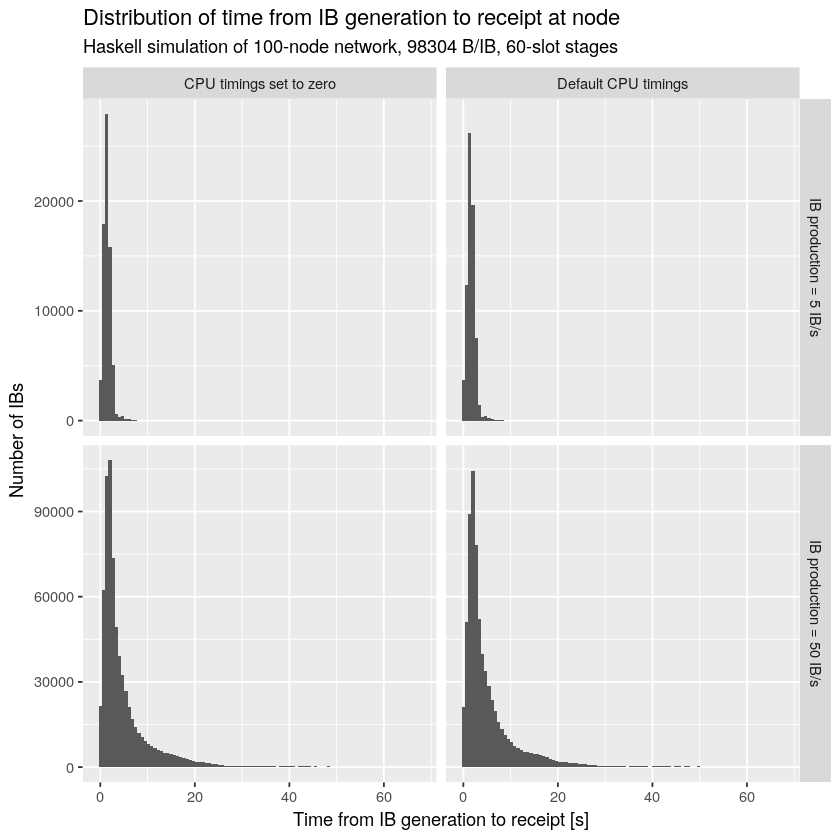

In [6]:
ggplot(receiptsCpu[, .(
        `label`=ifelse(`label` == "with-cpu", "Default CPU timings", "CPU timings set to zero"),
        `ibRate`=paste("IB production =", `ib-generation-probability`, "IB/s"),
        `elapsed`
    )], aes(x=`elapsed`)) +
    geom_histogram(bins=100) +
    facet_grid(`ibRate` ~ `label`, scales="free_y") +
    xlab("Time from IB generation to receipt [s]") +
    ylab("Number of IBs") +
    ggtitle(
        "Distribution of time from IB generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 98304 B/IB, 60-slot stages"
    )

In the plot above we see that the tail is quite long at high IB rate.

### Annotate with mean and 95th percentile

In [7]:
receiptCpuM <-
receiptsCpu[,
    .(
        `Mean [s]`=mean(`elapsed`),
        `95th percentile [s]`=quantile(`elapsed`, probs=0.95)
    ),
    by=.(
        `Label`=ifelse(`label` == "with-cpu", "Default CPU timings", "CPU timings set to zero"),
        `IB rate`=paste("IB production =", `ib-generation-probability`, "IB/s"),
        `ylabM`=ifelse(`ib-generation-probability` == 5, 7500, 30000),
        `ylab95`=ifelse(`ib-generation-probability` == 5, 6000, 25000)
    )
]
receiptCpuM

Label,IB rate,ylabM,ylab95,Mean [s],95th percentile [s]
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Default CPU timings,IB production = 5 IB/s,7500,6000,1.610656,2.907631
Default CPU timings,IB production = 50 IB/s,30000,25000,5.373003,17.668208
CPU timings set to zero,IB production = 5 IB/s,7500,6000,1.442184,2.658660
CPU timings set to zero,IB production = 50 IB/s,30000,25000,5.078874,16.951394


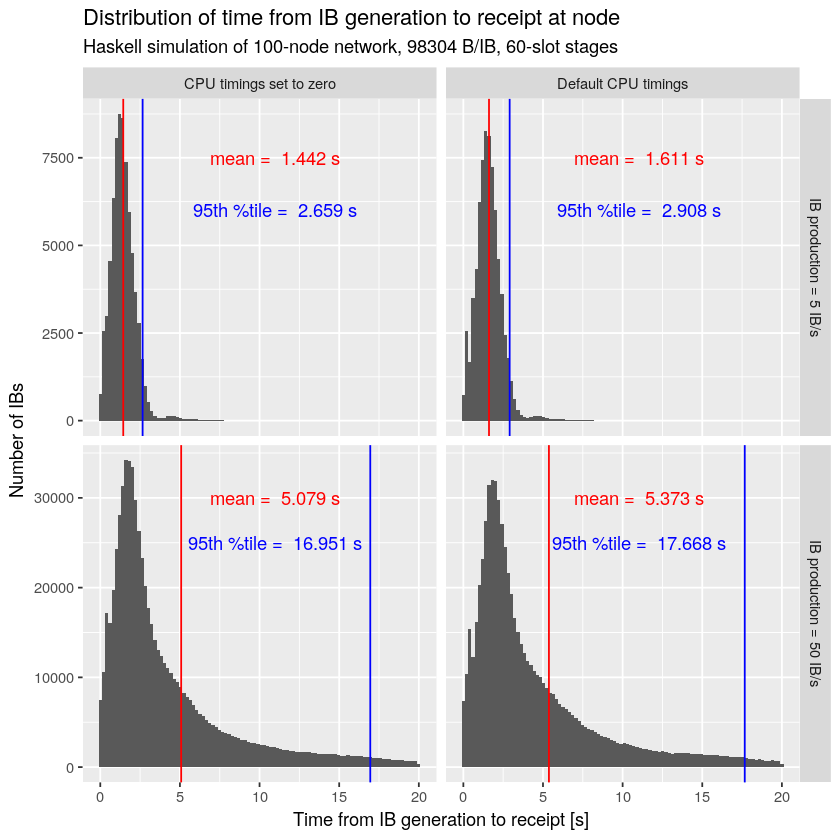

In [8]:
ggplot(receiptsCpu[`elapsed` <= 20,
    .(
        `Label`=ifelse(`label` == "with-cpu", "Default CPU timings", "CPU timings set to zero"),
        `IB rate`=paste("IB production =", `ib-generation-probability`, "IB/s"),
        `Time from IB generation to receipt [s]`=`elapsed`
    )
], aes(x=`Time from IB generation to receipt [s]`)) +
    geom_histogram(bins=100) +
    facet_grid(`IB rate` ~ `Label`, scales="free_y") +
    geom_vline(data=receiptCpuM, aes(xintercept=`Mean [s]`), color="red") +
    geom_text(data=receiptCpuM, aes(label=paste("mean = ", round(`Mean [s]`, 3), "s"), y=`ylabM`), x=11, color="red") +
    geom_vline(data=receiptCpuM, aes(xintercept=`95th percentile [s]`), color="blue") +
    geom_text(data=receiptCpuM, aes(label=paste("95th %tile = ", round(`95th percentile [s]`, 3), "s"), y=`ylab95`), x=11, color="blue") +
    ylab("Number of IBs") +
    ggtitle(
        "Distribution of time from IB generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 98304 B/IB, 60-slot stages"
    )

In the plot above we see that CPU usage does not account for a major portion of the delay.

In [9]:
ggsave("plots/receipts-cpu-comparison.svg", units="in", width=8, height=6, dpi=150)

In [10]:
ggsave("plots/receipts-cpu-comparison.png", units="in", width=8, height=6, dpi=150)

### IB rate vs IB size vs stage length

In [11]:
receiptsDefault <-
receipts[
    `simulator` == "haskell" & 
    `label` == "default" & 
    `network` == 100 &
    !is.na(`received`)
]

#### Histogram of elapsed time for all items

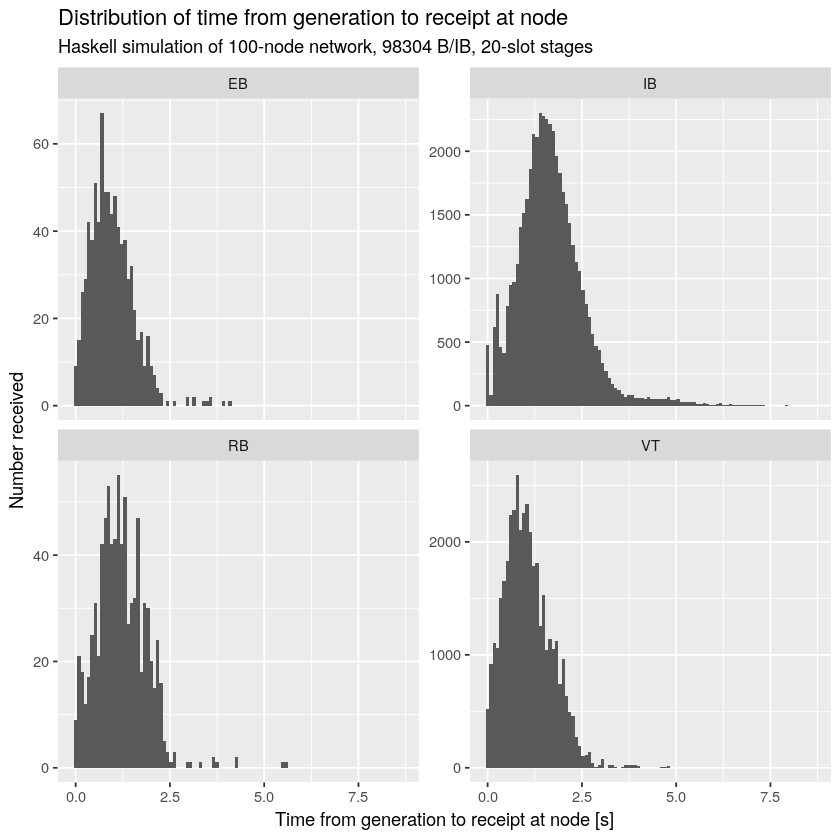

In [12]:
ggplot(
    receiptsDefault[`ib-generation-probability` == 3 & `ib-body-avg-size-bytes` == 98304 & `leios-stage-length-slots` == 20],
    aes(x=`elapsed`)
) +
    geom_histogram(bins=100) +
    facet_wrap(`kind` ~ ., scales="free_y") +
    xlab("Time from generation to receipt at node [s]") +
    ylab("Number received") +
    ggtitle(
        "Distribution of time from generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 98304 B/IB, 20-slot stages"
    )

In the plot above we see that the spread for IBs is greater than that for other messages.

In [13]:
ggsave("plots/receipts-items-histogram.svg", units="in", width=8, height=6, dpi=150)

In [14]:
ggsave("plots/receipts-items-histogram.png", units="in", width=8, height=6, dpi=150)

#### Variation of IB elapsed time with IB rate and size

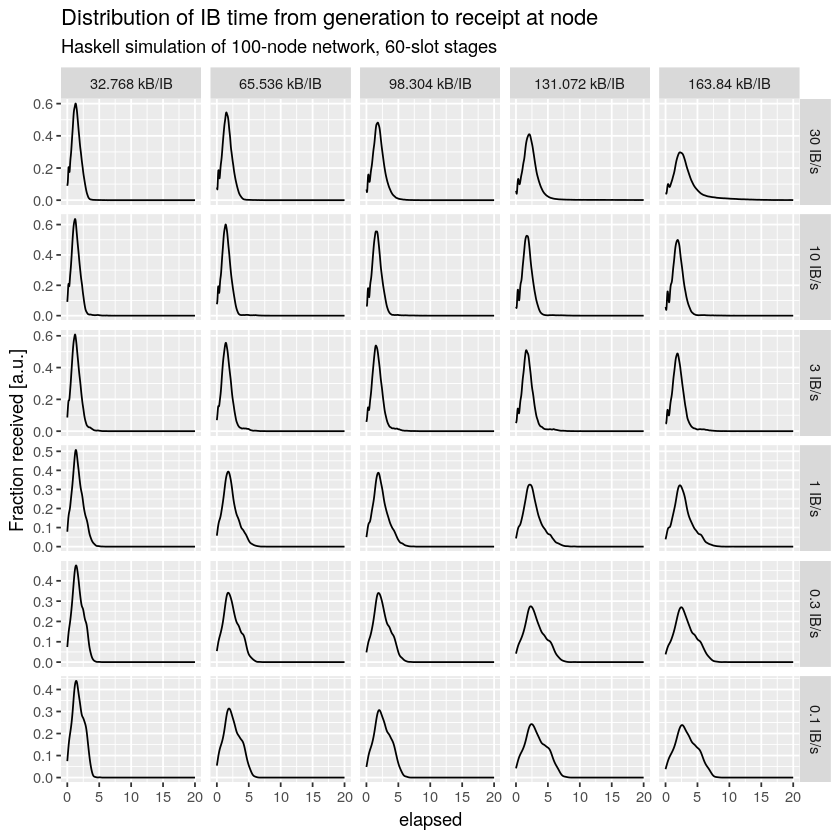

In [15]:
ggplot(
    receiptsDefault[
        `kind` == "IB" & `leios-stage-length-slots` == 60 & `elapsed` <= 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `elapsed`
        )
    ],
    aes(x=`elapsed`)
) +
    geom_density() +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Fraction received [a.u.]") +
    ggtitle(
        "Distribution of IB time from generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 60-slot stages"
    )

In the plot above, why does the distribution become more peaked and at lower latency when the IB rate is *higher*?

In [16]:
ggsave("plots/receipts-ibsize-density.svg", units="in", width=8, height=6, dpi=150)

In [17]:
ggsave("plots/receipts-ibsize-density.png", units="in", width=8, height=6, dpi=150)

#### Investigate the rightmost column

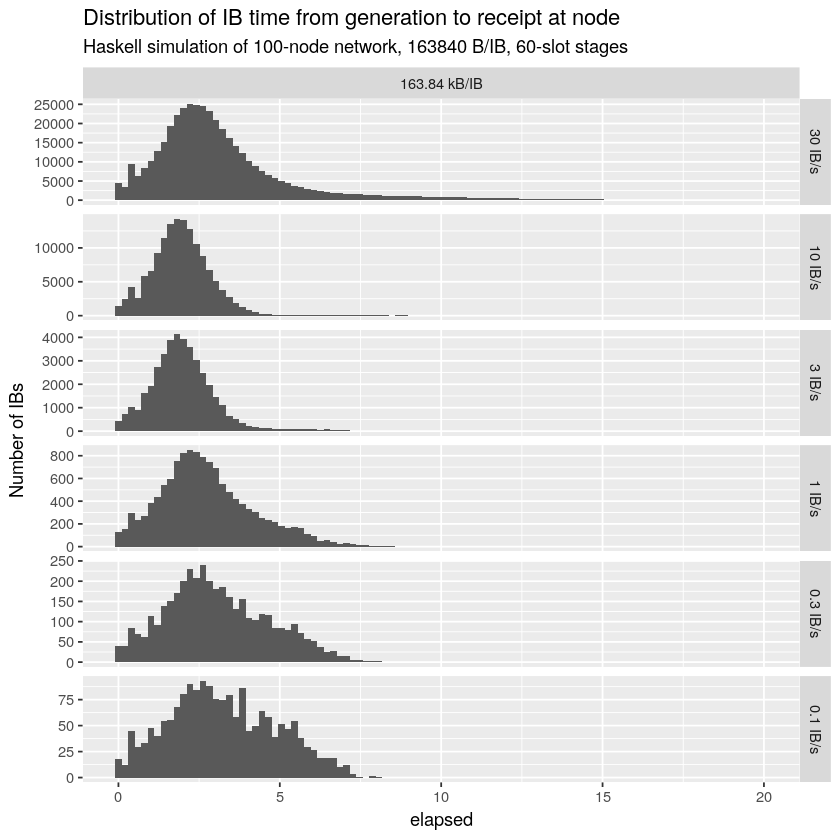

In [18]:
ggplot(
    receiptsDefault[
        `kind` == "IB" & `leios-stage-length-slots` == 60 & `elapsed` <= 20 & `ib-body-avg-size-bytes` == 163840,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `elapsed`
        )
    ],
    aes(x=`elapsed`)
) +
    geom_histogram(bins=100) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle(
        "Distribution of IB time from generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 163840 B/IB, 60-slot stages"
    )

In the plot above we see that fluctuations in the data are higher at lower IB rate.

In [19]:
ggsave("plots/receipts-ibsize-histogram.svg", units="in", width=8, height=6, dpi=150)

In [20]:
ggsave("plots/receipts-ibsize-histogram.png", units="in", width=8, height=6, dpi=150)

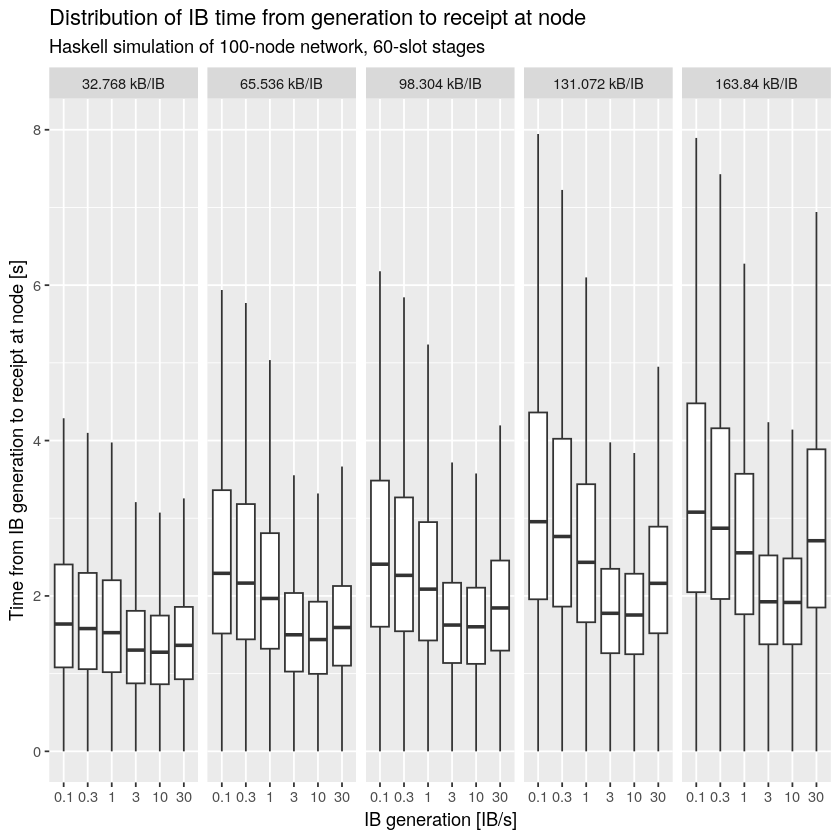

In [21]:
ggplot(
    receiptsDefault[
        `kind` == "IB" & `leios-stage-length-slots` == 60 & `elapsed` <= 20,
        .(
            `ib-generation-probability`,
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `elapsed`
        )
    ],
    aes(x=factor(`ib-generation-probability`), y=`elapsed`)
) +
    geom_boxplot(outlier.shape=NA) +
    facet_grid(. ~ `ibSize`) +
    coord_cartesian(ylim=c(0, 8)) +
    xlab("IB generation [IB/s]") +
    ylab("Time from IB generation to receipt at node [s]") +
    ggtitle(
        "Distribution of IB time from generation to receipt at node", 
        subtitle="Haskell simulation of 100-node network, 60-slot stages"
    )

In the plot above it is odd that the elapsed times appear to be shorter in the 3 IB/s to 10 IB/s range. However, this might not be statistically significant.

In [22]:
ggsave("plots/receipts-ibsize-boxplot.svg", units="in", width=8, height=6, dpi=150)

In [23]:
ggsave("plots/receipts-ibsize-boxplot.png", units="in", width=8, height=6, dpi=150)

#### Compare the distributions of elapsed times

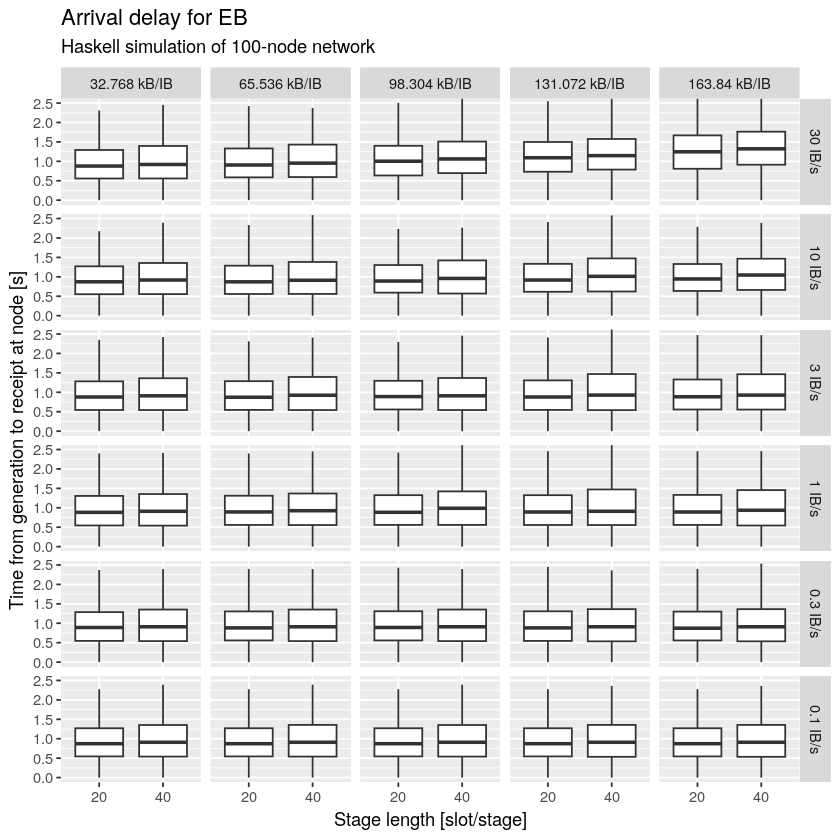

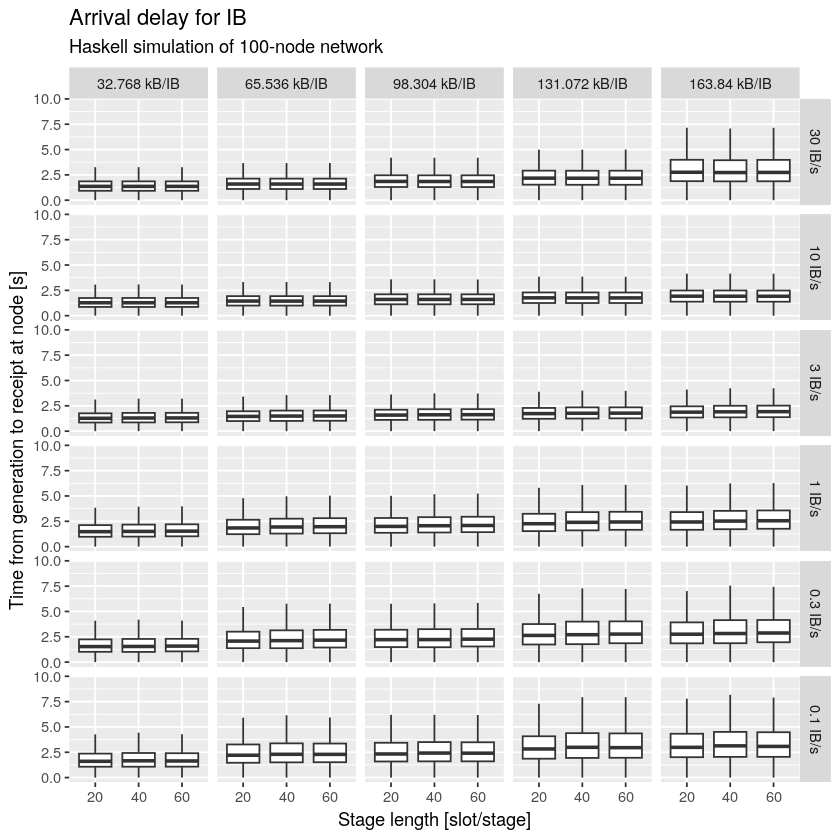

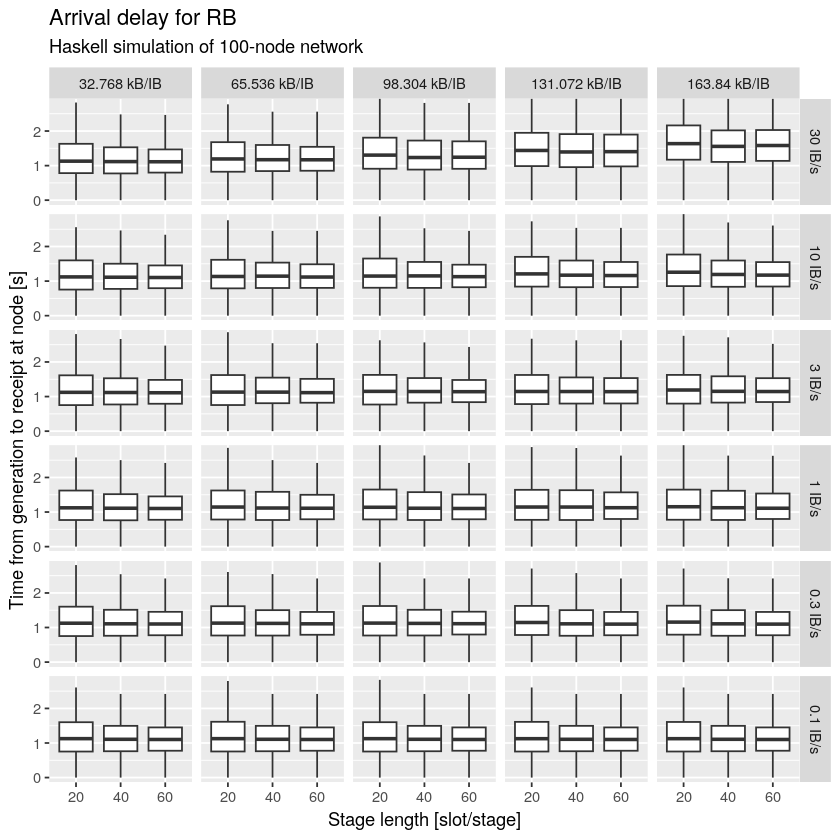

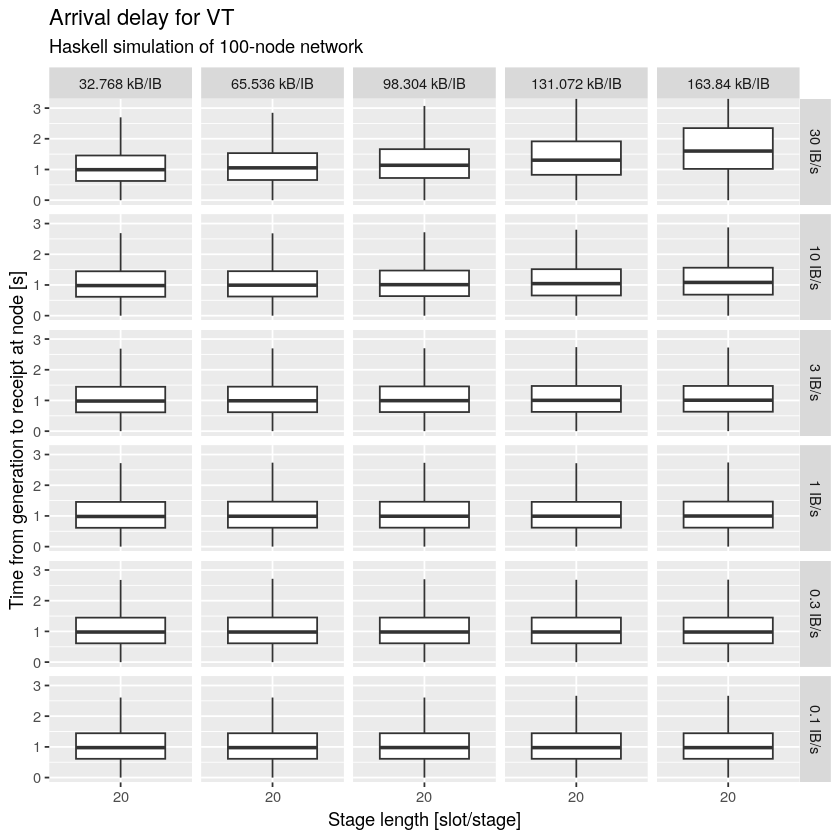

In [24]:
for (k in receiptsDefault[,unique(`kind`)]) {
    g <- ggplot(
        receiptsDefault[
            `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `stageLength`=factor(`leios-stage-length-slots`),
                `elapsed`
            )
        ],
        aes(x=`stageLength`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`ibRate` ~ `ibSize`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("Stage length [slot/stage]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle="Haskell simulation of 100-node network")
    print(g)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-1.svg"), plot=g, units="in", width=8, height=6, dpi=150)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-1.png"), plot=g, units="in", width=8, height=6, dpi=150)
}

The plot above indicates that varying the stage length does not significantly affect any of the distributions.

#### Trends in elapsed times

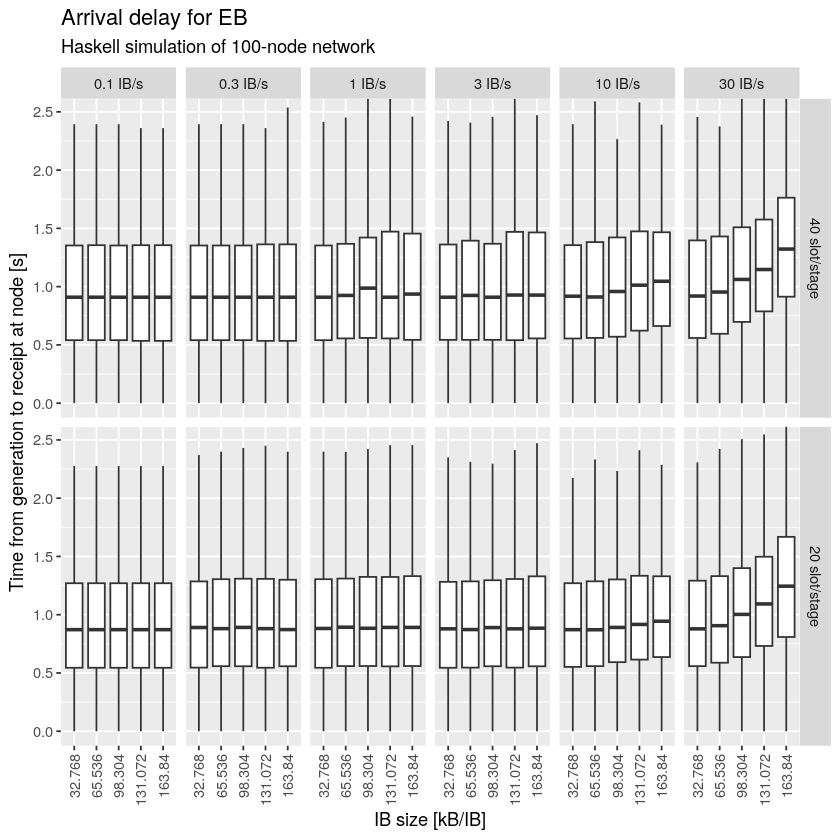

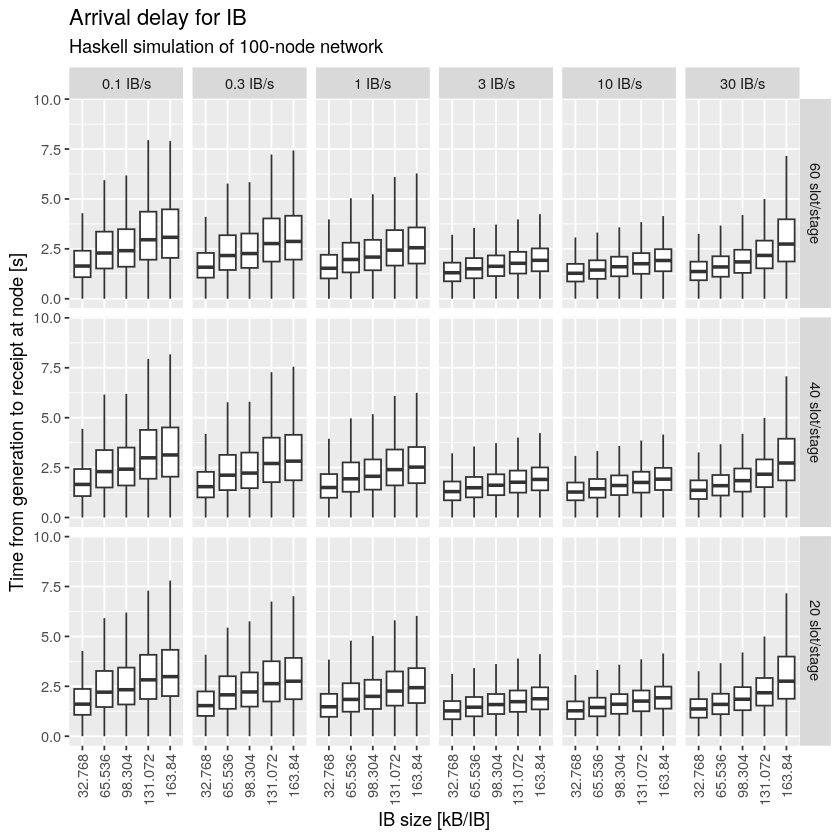

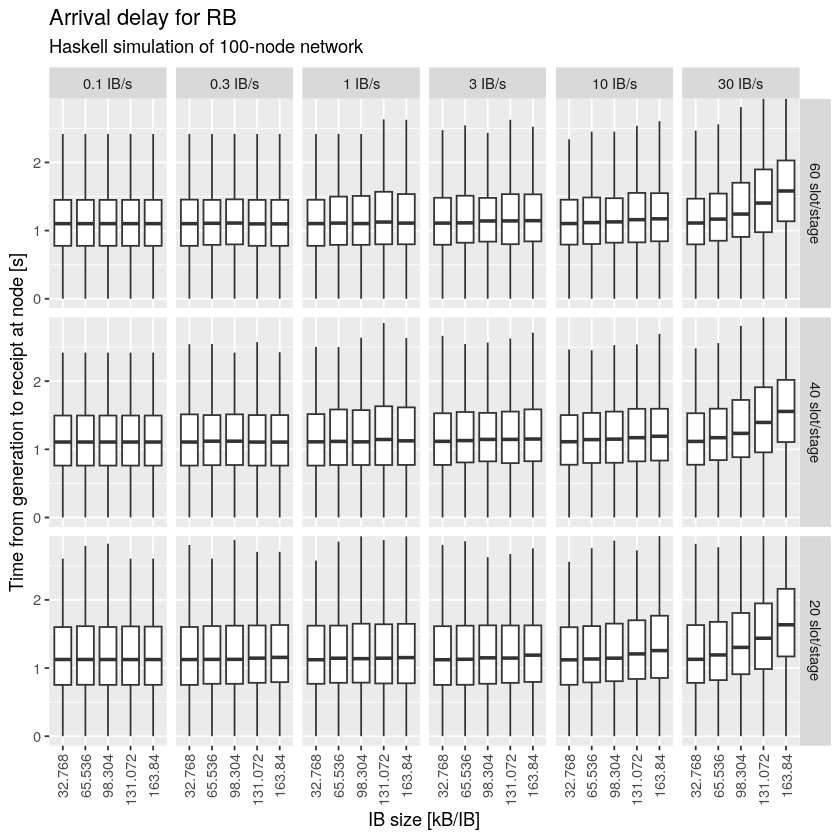

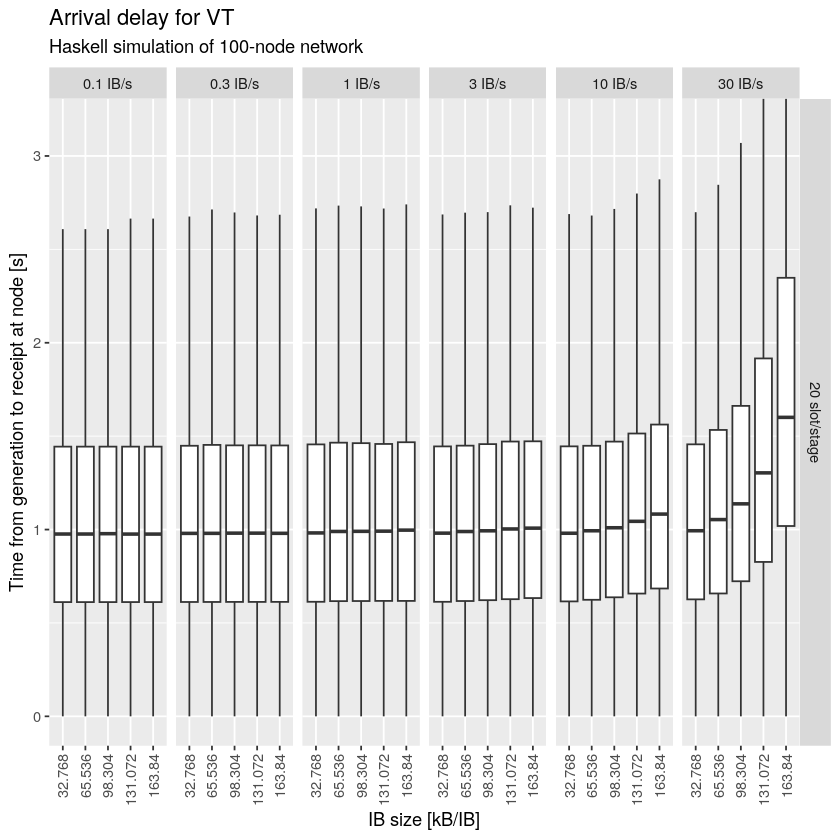

In [25]:
for (k in receiptsDefault[,unique(`kind`)]) {
    g <- ggplot(
        receiptsDefault[
            `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`))], "IB/s")),
                `ibSize`=factor(`ib-body-avg-size-bytes`/1000),
                `stageLength`=factor(paste(`leios-stage-length-slots`, "slot/stage"), levels=paste(receiptsDefault[, sort(unique(`leios-stage-length-slots`),decreasing=TRUE)], "slot/stage")),
                `elapsed`
            )
        ],
        aes(x=`ibSize`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`stageLength` ~ `ibRate`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("IB size [kB/IB]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle="Haskell simulation of 100-node network") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

    print(g)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-2.svg"), plot=g, units="in", width=8, height=6, dpi=150)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-2.png"), plot=g, units="in", width=8, height=6, dpi=150)
}

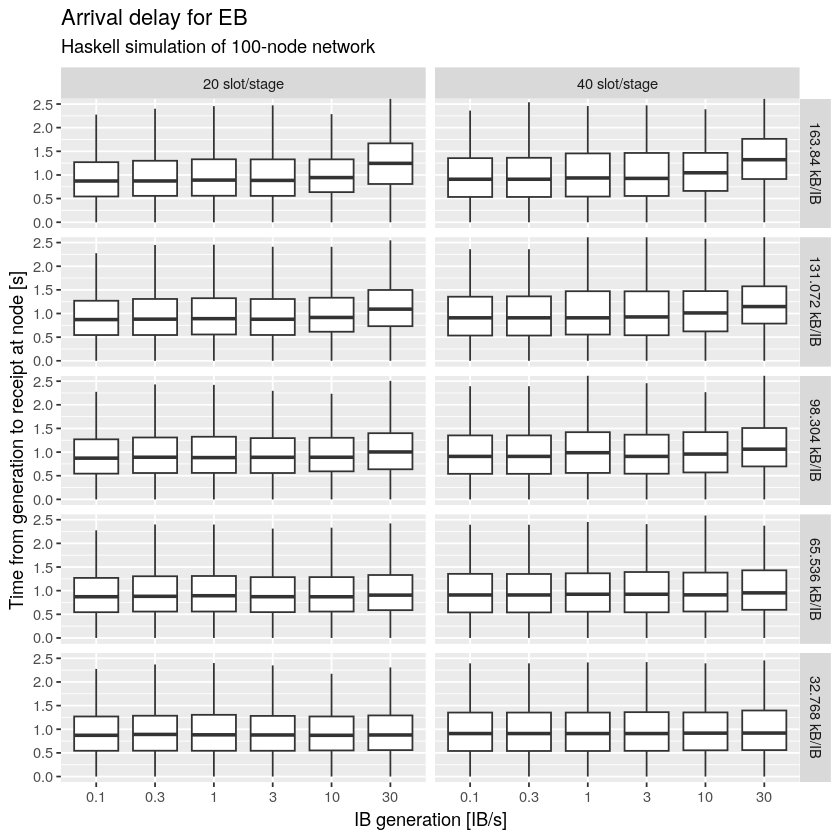

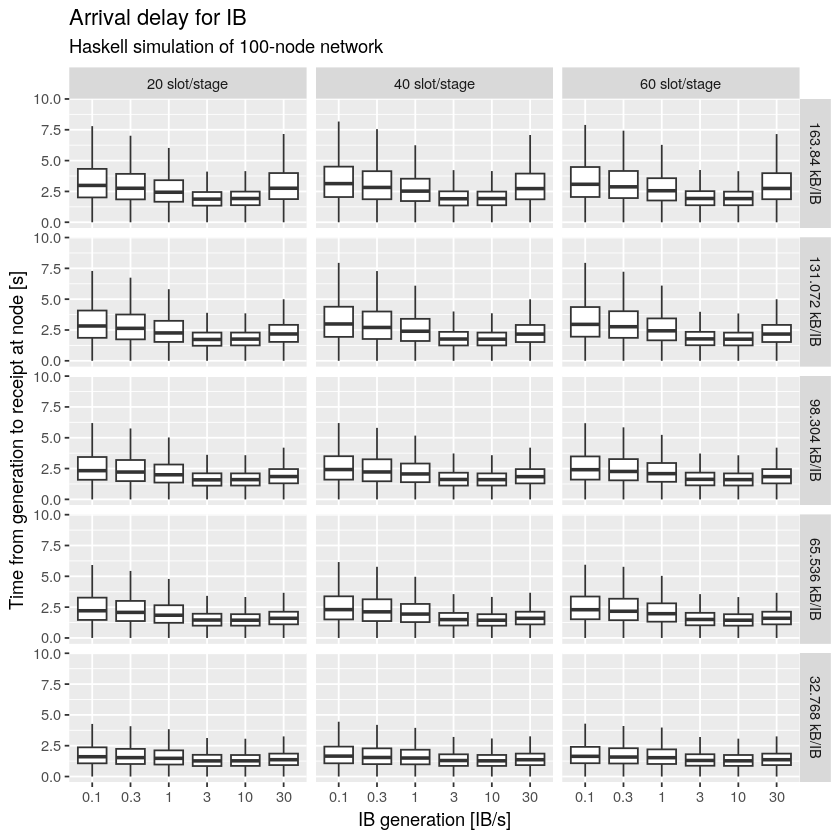

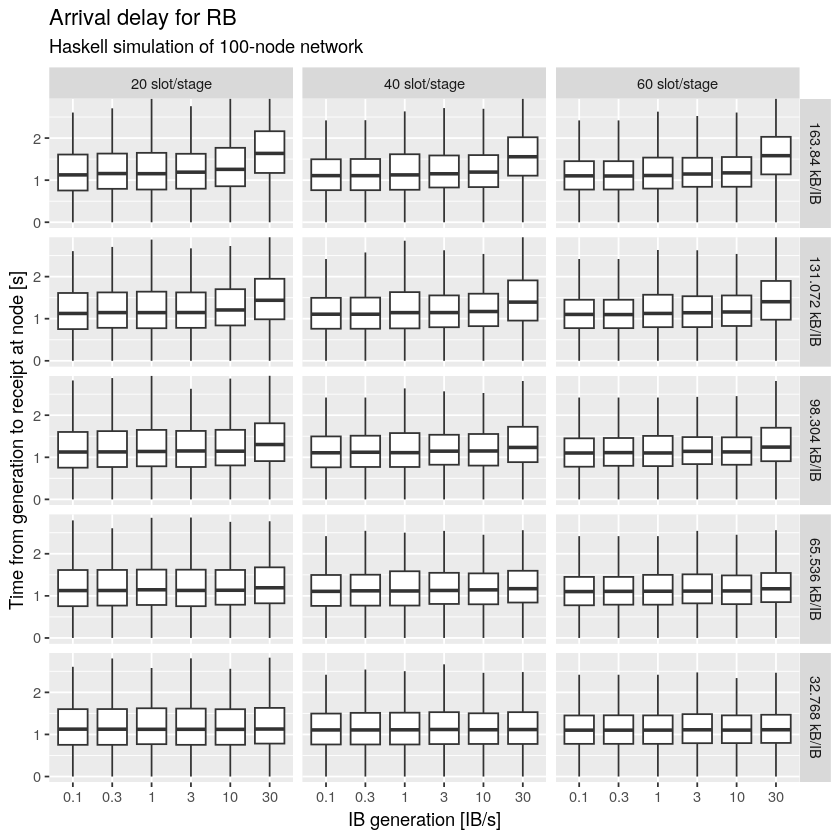

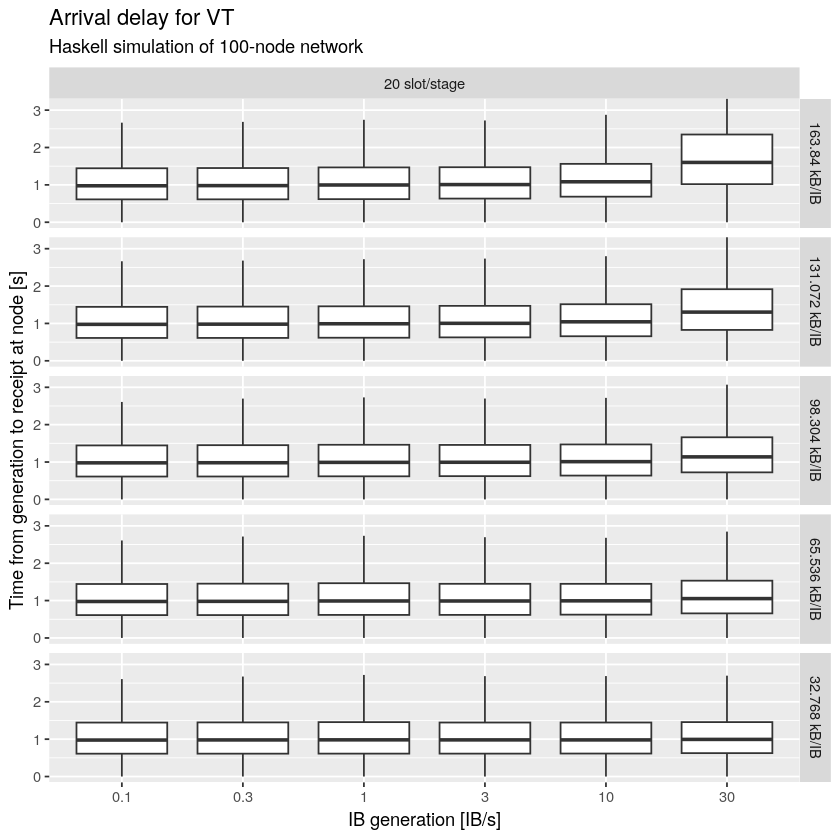

In [26]:
for (k in receiptsDefault[,unique(`kind`)]) {
    g <- ggplot(
        receiptsDefault[
            `kind` == k,
            .(
                `ibRate`=factor(`ib-generation-probability`),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`),decreasing=TRUE)]/1000, "kB/IB")),
                `stageLength`=factor(paste(`leios-stage-length-slots`, "slot/stage"), levels=paste(receiptsDefault[, sort(unique(`leios-stage-length-slots`))], "slot/stage")),
                `elapsed`
            )
        ],
        aes(x=`ibRate`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`ibSize` ~ `stageLength`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("IB generation [IB/s]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle="Haskell simulation of 100-node network")

    print(g)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-3.svg"), plot=g, units="in", width=8, height=6, dpi=150)
    ggsave(file=paste0("plots/receipts-", k, "-boxplot-3.png"), plot=g, units="in", width=8, height=6, dpi=150)
}

The plot above indicates that varying the stage length does not significantly affect any of the distributions.

### Fraction of items arriving

In [27]:
arrival <- receiptsDefault[,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`)
]

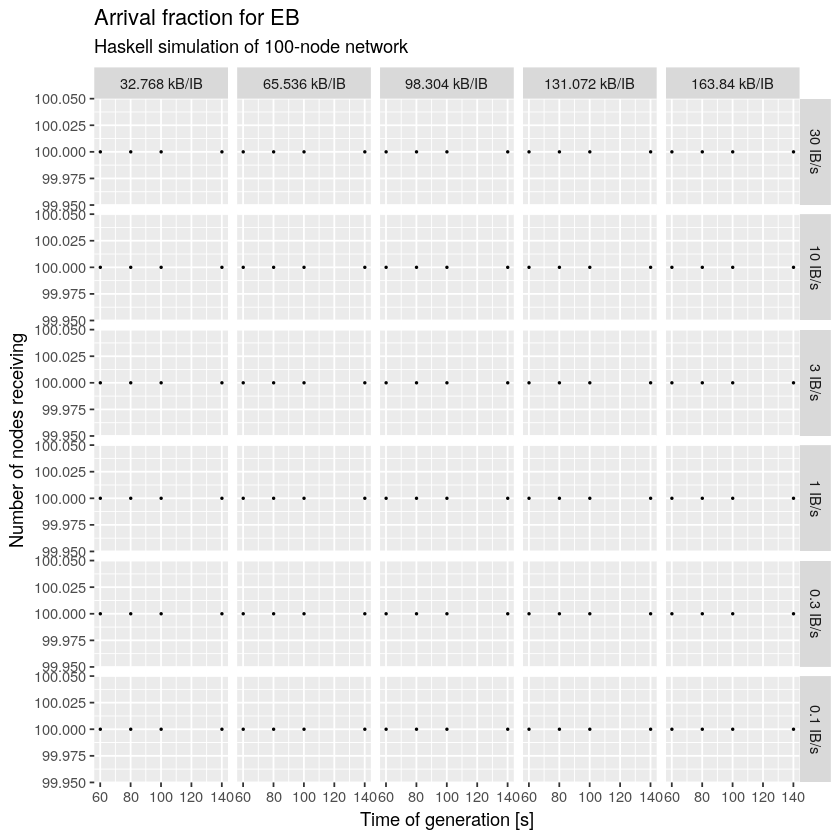

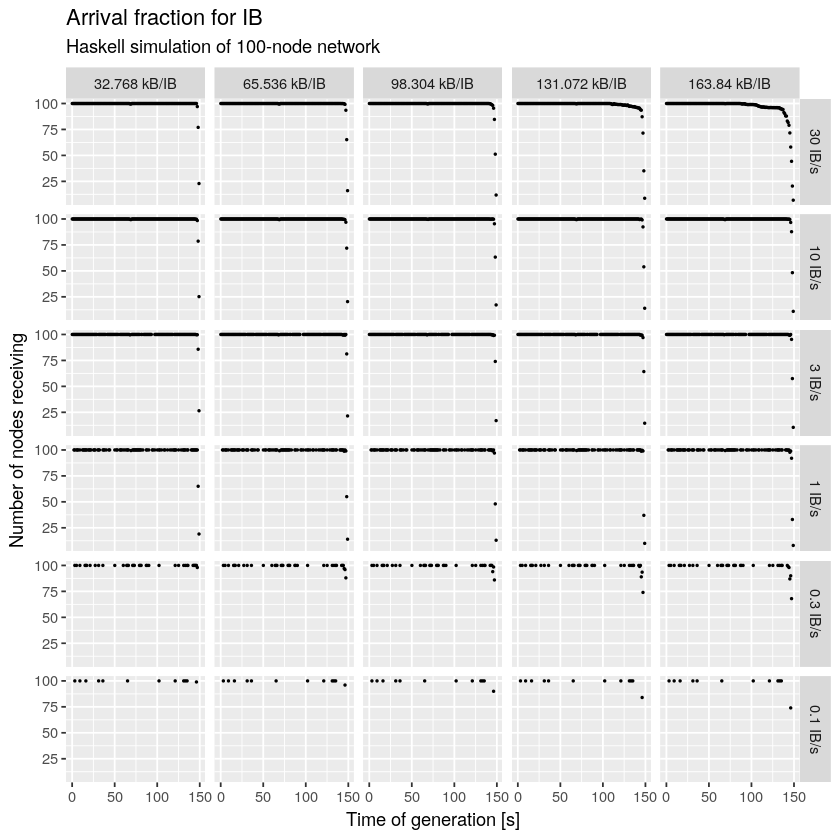

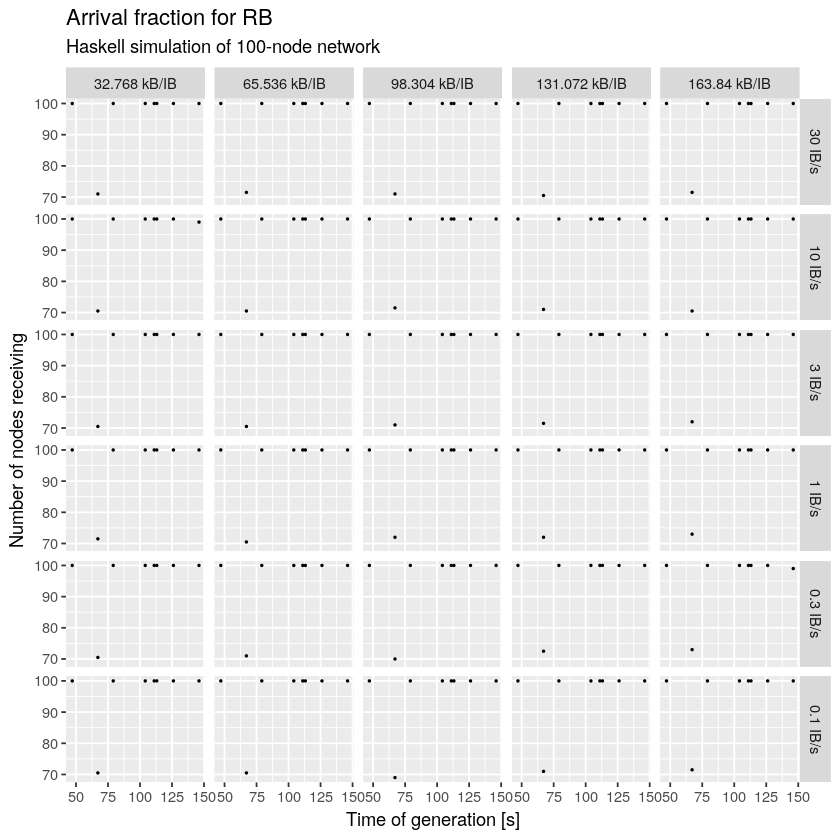

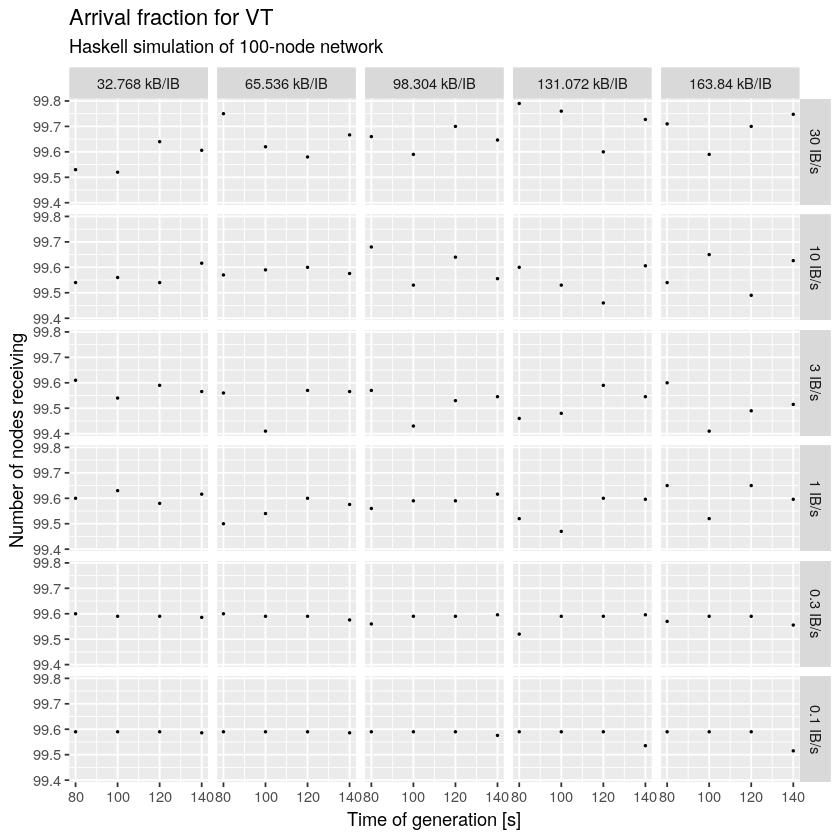

In [28]:
for (k in receiptsDefault[,unique(`kind`)]) {
    g <- ggplot(
        arrival[
            `kind` == k & `leios-stage-length-slots` == 20,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.3) +
        facet_grid(`ibRate`  ~ `ibSize`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle="Haskell simulation of 100-node network")
    print(g)
}

## CPU usage

### Read results

In [29]:
cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w10", collection="cpus")$find(), stringsAsFactors=TRUE)
cpus %>% summary

    duration          simulator            node            slot       
 Min.   :0.000328   haskell:2329869   Min.   : 0.00   Min.   :  0.00  
 1st Qu.:0.011424                     1st Qu.:24.00   1st Qu.: 41.00  
 Median :0.115536                     Median :49.00   Median : 79.00  
 Mean   :0.451523                     Mean   :49.48   Mean   : 77.42  
 3rd Qu.:0.341000                     3rd Qu.:74.00   3rd Qu.:114.00  
 Max.   :6.068320                     Max.   :99.00   Max.   :150.00  
                                                                      
      task             label         network       ib-generation-probability
 ValIH  :1121488   default:2329869   100:2329869   Min.   : 0.10            
 ValIB  : 867771                                   1st Qu.: 1.00            
 ValRH  : 132397                                   Median : 3.00            
 GenIB  :  87775                                   Mean   :10.11            
 ValRB  :  51337                               

In [30]:
fwrite(cpus, "results/cpus.csv")

In [31]:
cpusNode <-
cpus[
    `simulator` == "haskell" & `network` == "100",
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

### Peak CPU usage

#### Histogram

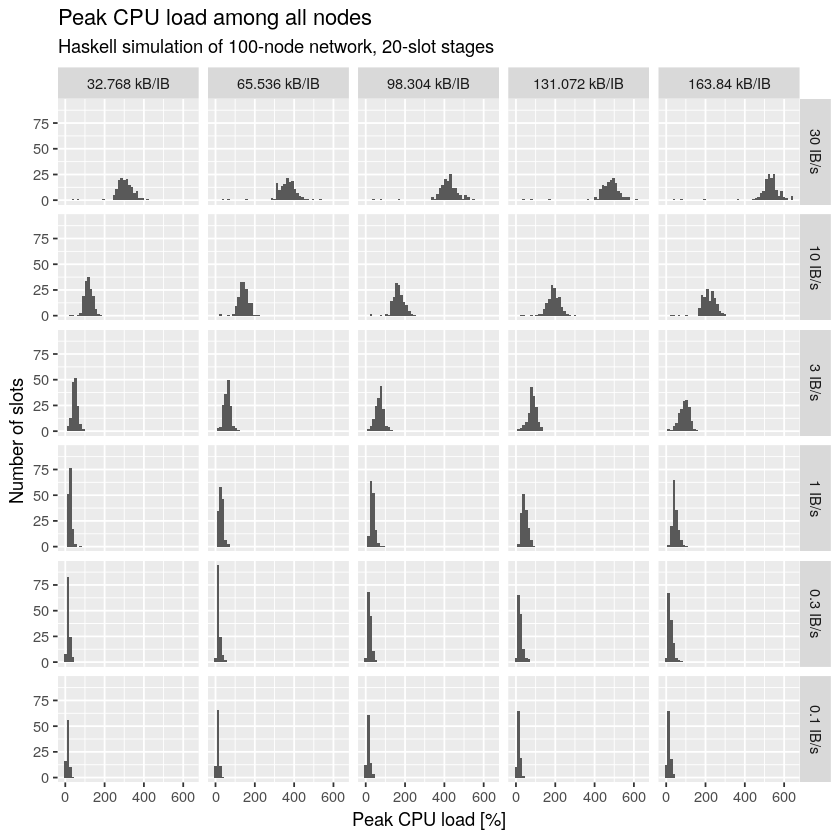

In [32]:
ggplot(
    cpusNode[
        `leios-stage-length-slots` == 20,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(bins=50) +
#   geom_vline(xintercept=100, color="blue") +
    facet_grid(`ibRate` ~ `ibSize`) +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that eight vCPUs is sufficient for any of the compute loads in the simulations.

In [33]:
ggsave("plots/cpus-peak.svg", units="in", width=8, height=6, dpi=150)

In [34]:
ggsave("plots/cpus-peak.png", units="in", width=8, height=6, dpi=150)

#### Time series

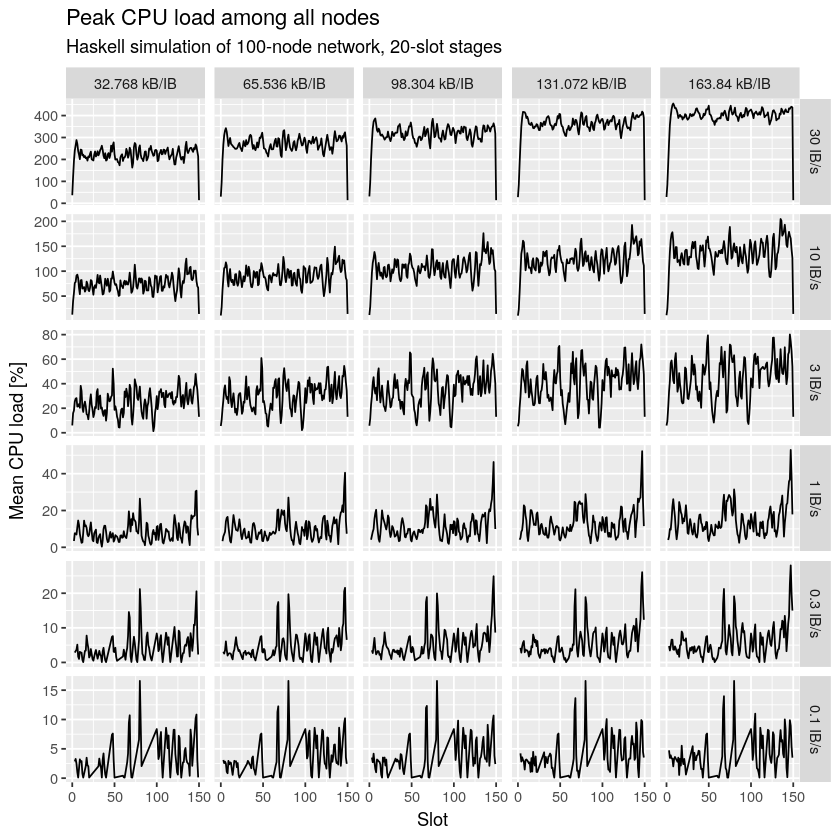

In [35]:
ggplot(
    cpusNode[
        `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we that CPU loads are uneven at lower IB rates.

### Mean CPU usage

#### Histogram

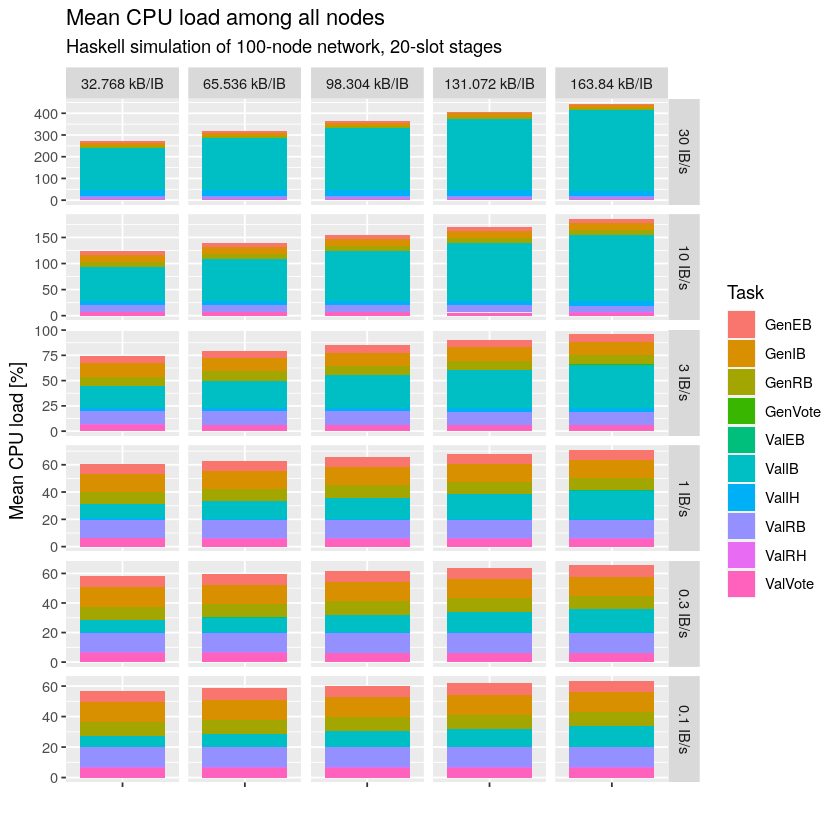

In [36]:
ggplot(
    cpus[
        `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=`task`
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that IB validation tends to domainate CPU usage, except at low IB rate.

In [37]:
ggsave("plots/cpu-mean-histogram.svg", units="in", width=8, height=6, dpi=150)

In [38]:
ggsave("plots/cpu-mean-histogram.png", units="in", width=8, height=6, dpi=150)

#### Time series

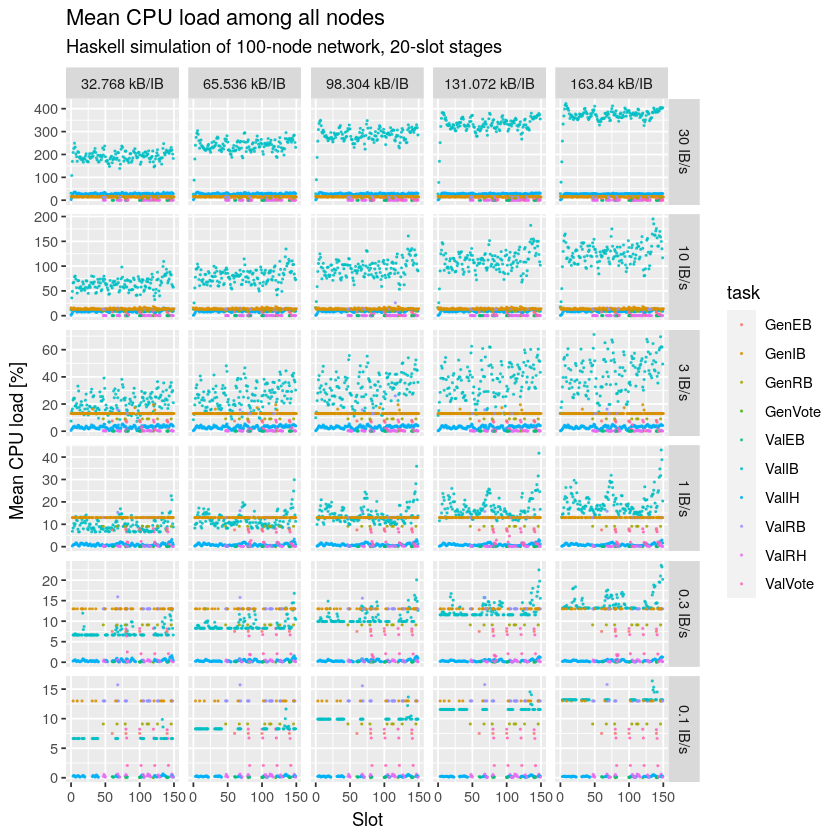

In [39]:
ggplot(
    cpus[
        `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that voting is the most sporadic load on CPU.

In [40]:
ggsave("plots/cpu-mean-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [41]:
ggsave("plots/cpu-mean-timeseries.png", units="in", width=8, height=6, dpi=150)

### Fraction throttled

In [42]:
# TBD

### Idle time

In [43]:
# TBD

## Input blocks

### Read results

In [44]:
ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w10", collection="ibgen")$find(), stringsAsFactors=TRUE)
ibgen %>% summary

      node            time             size           eb-count     
 node-40: 1365   Min.   :  0.13   Min.   : 33072   Min.   :0.0000  
 node-96: 1330   1st Qu.: 37.13   1st Qu.: 65840   1st Qu.:0.0000  
 node-14: 1315   Median : 75.13   Median : 98608   Median :0.0000  
 node-97: 1315   Mean   : 75.53   Mean   : 98608   Mean   :0.6123  
 node-19: 1260   3rd Qu.:114.13   3rd Qu.:131376   3rd Qu.:1.0000  
 node-4 : 1205   Max.   :149.13   Max.   :164144   Max.   :3.0000  
 (Other):89565                                                     
    eb-first         eb-last         simulator           ib       
 Min.   : 60.08   Min.   : 60.08   haskell:97355   23-0   :   90  
 1st Qu.: 80.08   1st Qu.: 80.08                   35-0   :   90  
 Median :120.08   Median :120.08                   47-0   :   90  
 Mean   :103.29   Mean   :103.29                   52-0   :   90  
 3rd Qu.:120.08   3rd Qu.:120.08                   81-0   :   90  
 Max.   :140.07   Max.   :140.07                   33-

In [45]:
fwrite(ibgen, "results/ibgen.csv")

### IB inculsion in EBs

#### Histogram

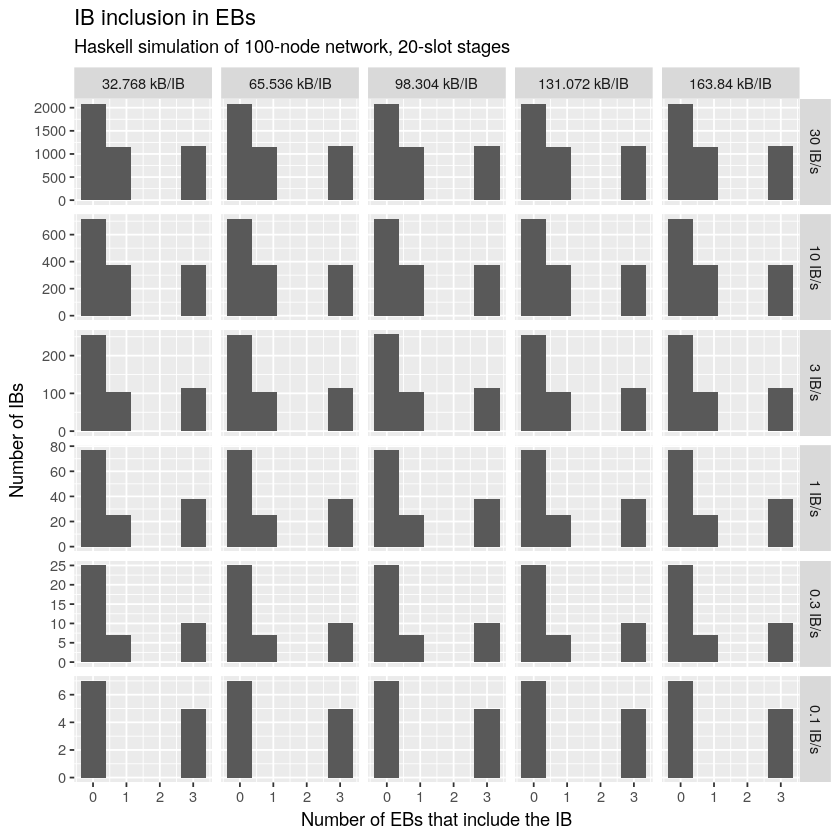

In [46]:
ggplot(
    ibgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that IBs are often referenced by three EBs.

In [47]:
ggsave("plots/ib-inclusion-histogram.svg", units="in", width=8, height=6, dpi=150)

In [48]:
ggsave("plots/ib-inclusion-histogram.png", units="in", width=8, height=6, dpi=150)

#### Time series

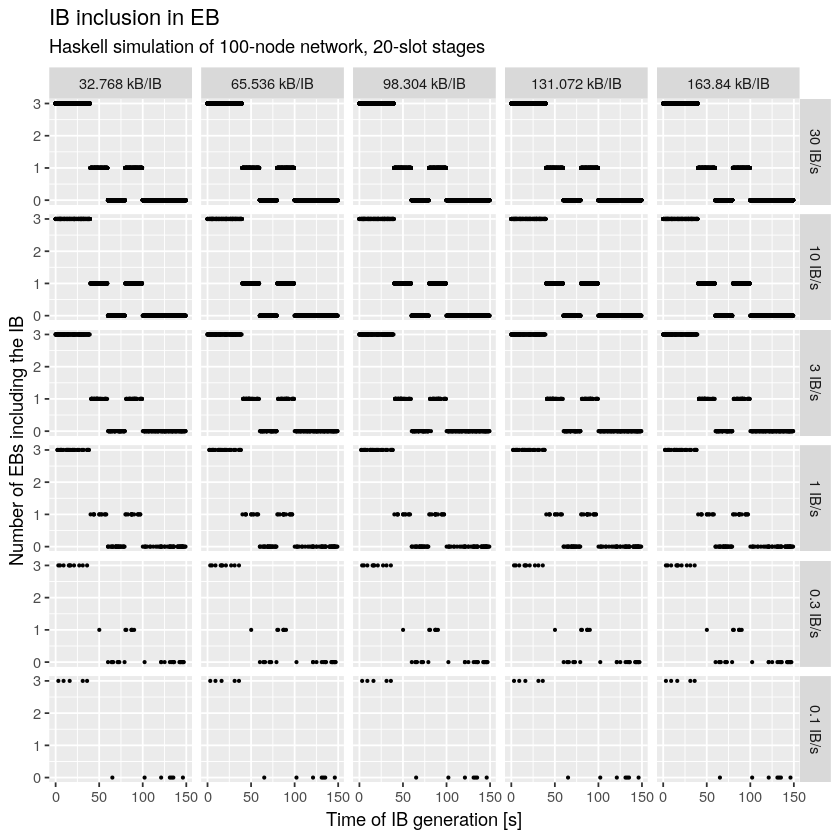

In [49]:
ggplot(
    ibgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that some IBs are never referenced by EBs.

In [50]:
ggsave("plots/ib-inclusion-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [51]:
ggsave("plots/ib-inclusion-timeseries.png", units="in", width=8, height=6, dpi=150)

### Time of IB inclusion in an EB

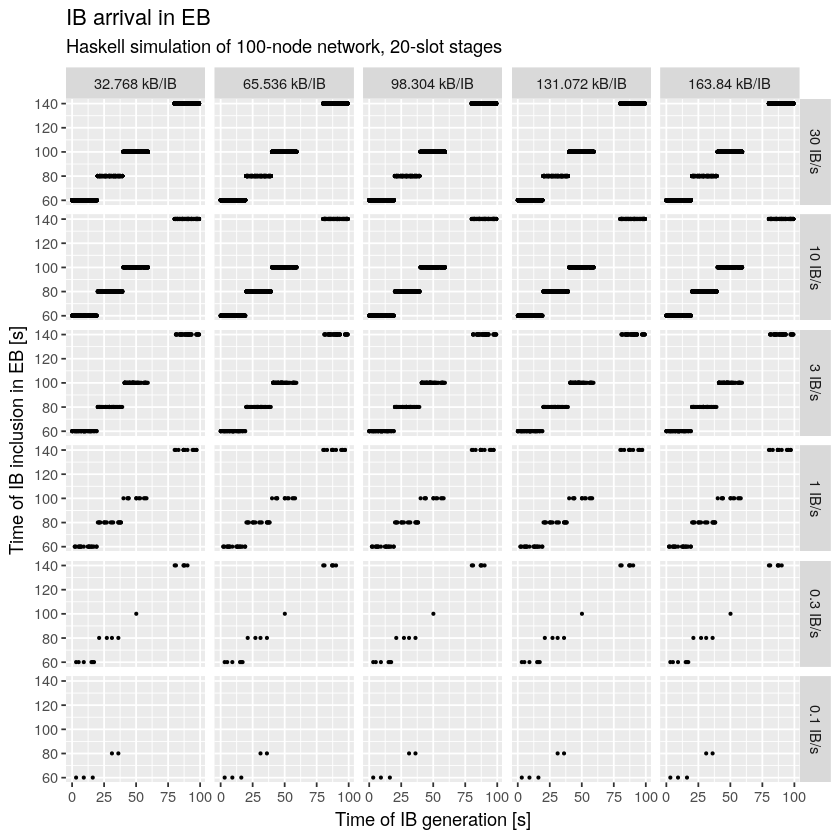

In [52]:
ggplot(
    ibgen[
        `leios-stage-length-slots` == 20 & !is.na(`eb-first`),
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see the expected pattern of pipeline stage operation.

In [53]:
ggsave("plots/ib-arrival-in-eb.svg", units="in", width=8, height=6, dpi=150)

In [54]:
ggsave("plots/ib-arrival-in-eb.png", units="in", width=8, height=6, dpi=150)

### IB size

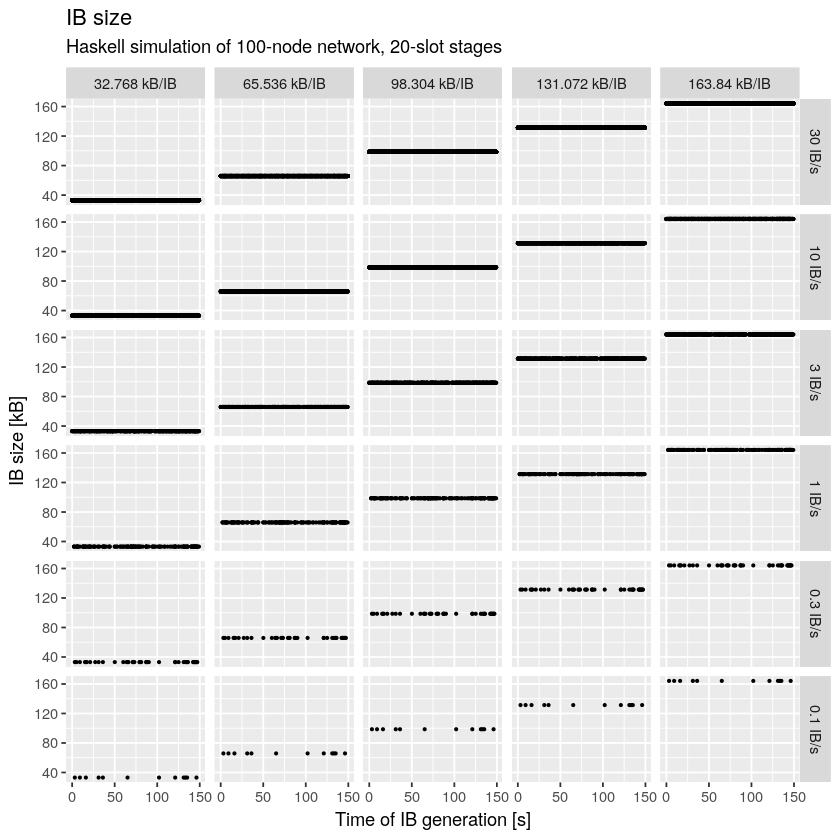

In [55]:
ggplot(
    ibgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that IB sizes match the experimental design for the scenarios.

In [56]:
ggsave("plots/ib-size.svg", units="in", width=8, height=6, dpi=150)

In [57]:
ggsave("plots/ib-size.png", units="in", width=8, height=6, dpi=150)

## Endorser blocks

### Read results

In [58]:
ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w10", collection="ebgen")$find(), stringsAsFactors=TRUE)
ebgen %>% summary

      node         time             size           ib-count     
 node-90:90   Min.   : 60.08   Min.   : 672.0   Min.   :   0.0  
 node-10:30   1st Qu.: 60.08   1st Qu.: 672.0   1st Qu.:   6.0  
 node-13:30   Median : 80.08   Median : 672.0   Median :  43.0  
 node-14:30   Mean   : 92.80   Mean   : 846.5   Mean   : 180.6  
 node-22:30   3rd Qu.:120.08   3rd Qu.:1312.0   3rd Qu.: 191.0  
 node-4 :30   Max.   :140.07   Max.   :1312.0   Max.   :1169.0  
 (Other):90                                                     
    rb-count         rb-first        rb-last        simulator         eb     
 Min.   :0.0000   Min.   :104.1   Min.   :104.1   haskell:330   90-0   : 30  
 1st Qu.:0.0000   1st Qu.:104.1   1st Qu.:104.1                 15-1   : 15  
 Median :0.0000   Median :111.1   Median :111.1                 2-0    : 15  
 Mean   :0.2727   Mean   :113.8   Mean   :113.8                 45-0   : 15  
 3rd Qu.:1.0000   3rd Qu.:126.1   3rd Qu.:126.1                 57-1   : 15  
 Max.   :1.0

In [59]:
fwrite(ebgen, "results/ebgen.csv")

### EB inclusion in RBs

#### Histogram

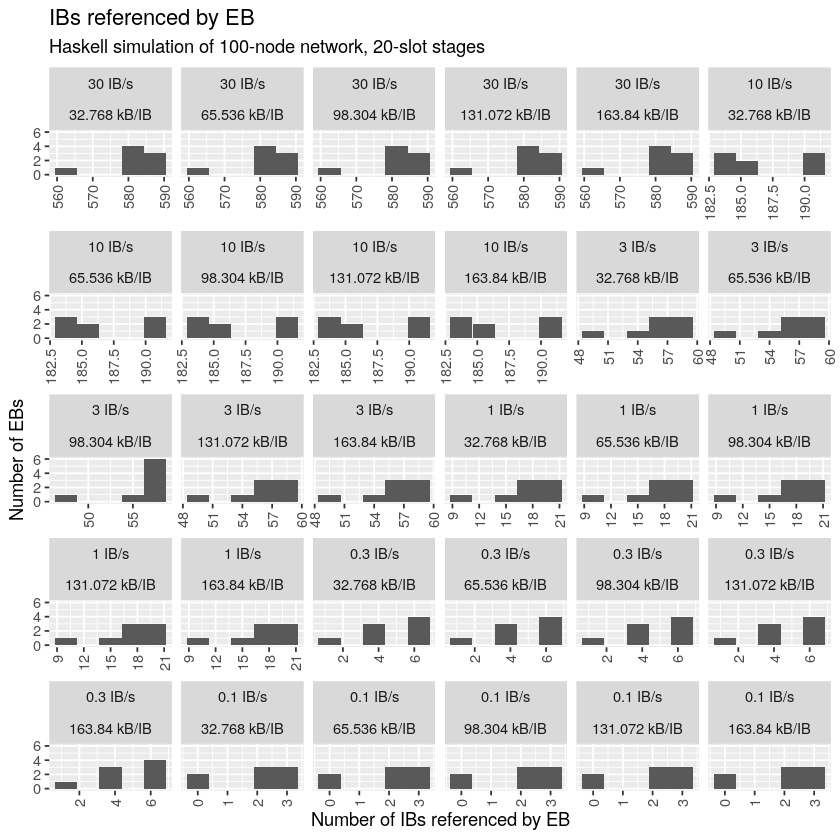

In [60]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle="Haskell simulation of 100-node network, 20-slot stages") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

In the plot above we see that EBs reference large numbers of IBs at the higher throughput and that some EBs are empty.

In [61]:
ggsave("plots/eb-referencing-histogram.svg", units="in", width=8, height=6, dpi=150)

In [62]:
ggsave("plots/eb-referencing-histogram.png", units="in", width=8, height=6, dpi=150)

#### Time series

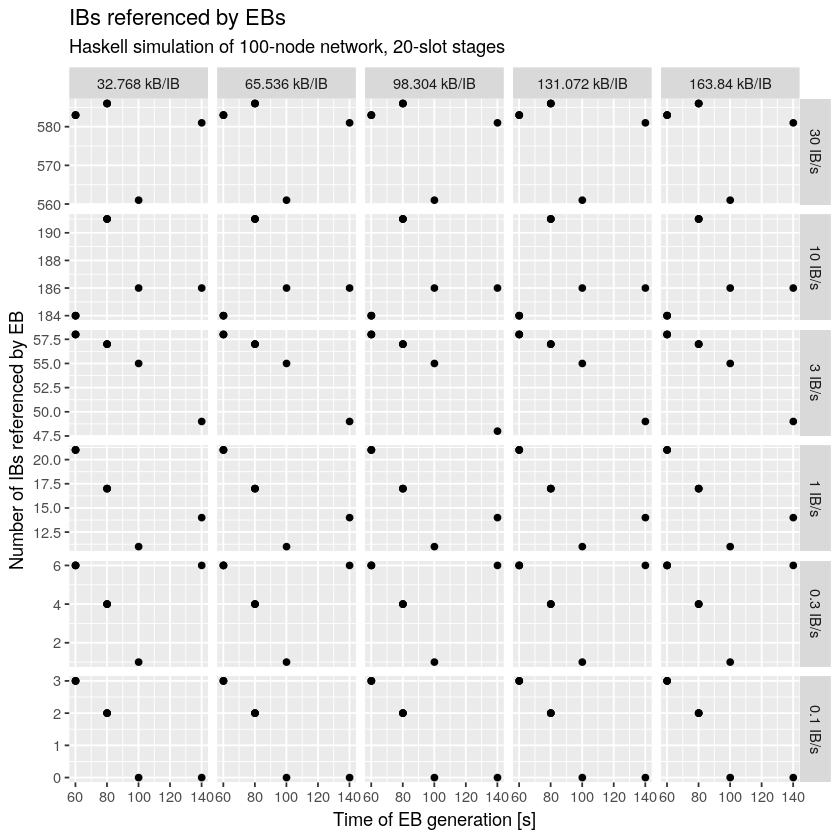

In [63]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that no EB was produced in the fourth pipeline.

In [64]:
ggsave("plots/eb-referencing-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [65]:
ggsave("plots/eb-referencing-timeseries.png", units="in", width=8, height=6, dpi=150)

### EB inclusion in RBs

#### Histogram

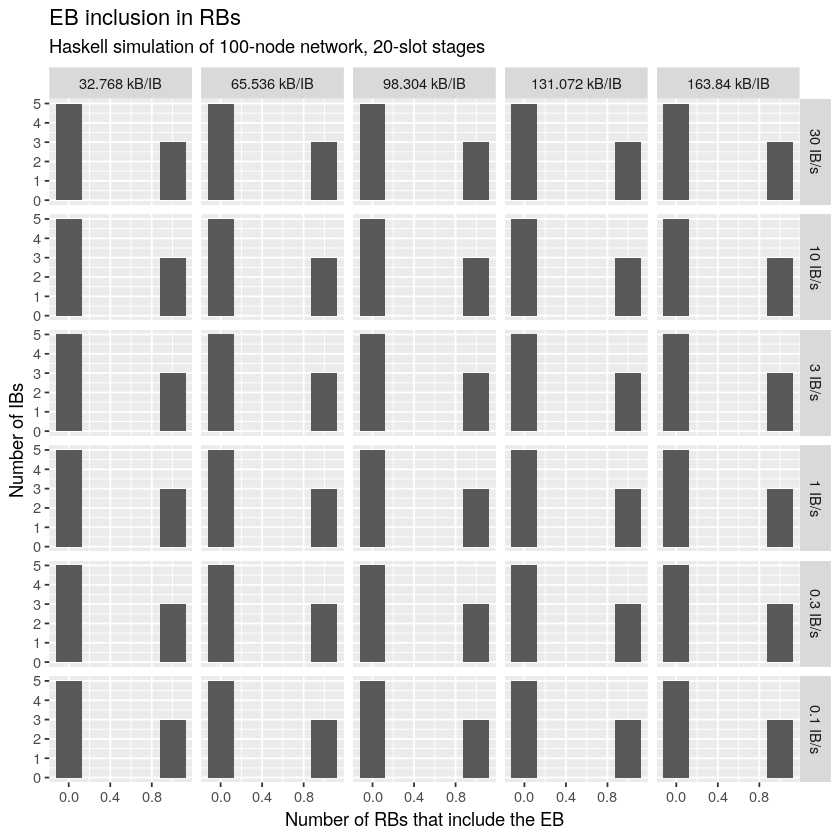

In [66]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("EB inclusion in RBs", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that RBs never reference more than one EB and that many RBs reference none.

In [67]:
ggsave("plots/eb-inclusion-histogram.svg", units="in", width=8, height=6, dpi=150)

In [68]:
ggsave("plots/eb-inclusion-histogram.png", units="in", width=8, height=6, dpi=150)

#### Time series

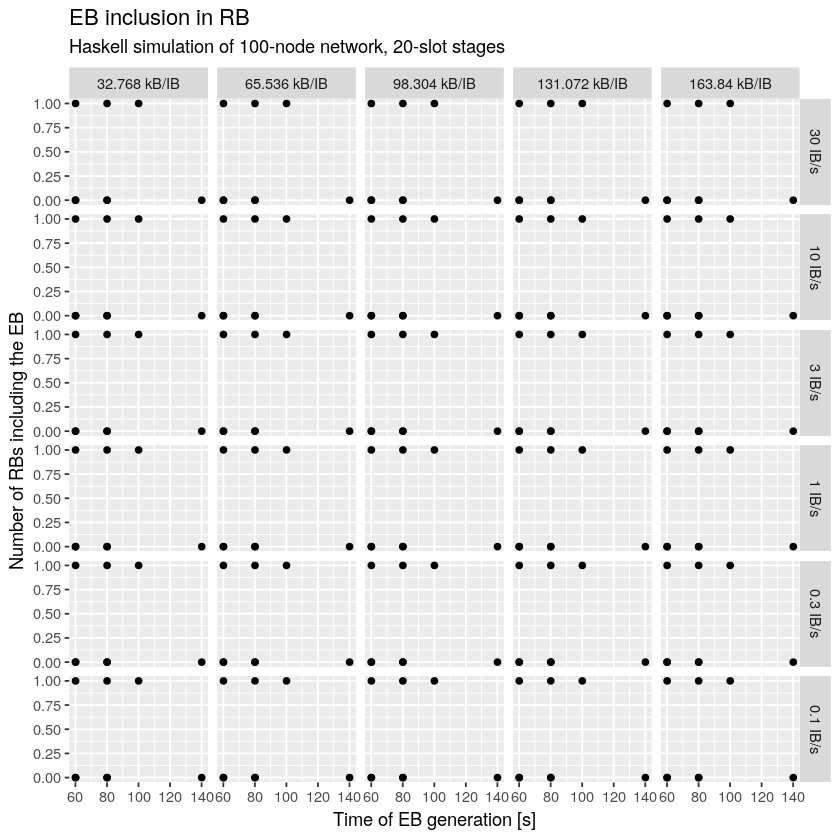

In [69]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that the protocol only selects on EB for referencing in the RB, even if there are several candidates.

In [70]:
ggsave("plots/eb-inclusion-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [71]:
ggsave("plots/eb-inclusion-timeseries.png", units="in", width=8, height=6, dpi=150)

### Time of EB inclusion in an RB

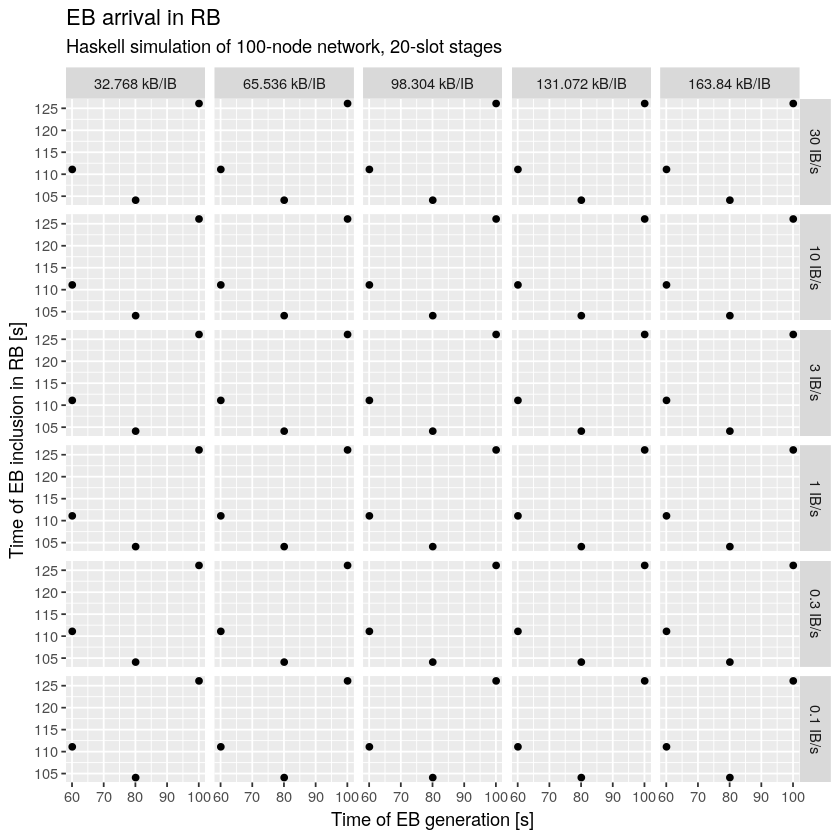

In [72]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20 & `rb-count` > 0,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see odd behavior that a later EB is referenced in an RB even though an earlier EB was available.

In [73]:
ggsave("plots/eb-arrival-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [74]:
ggsave("plots/eb-arrival-timeseries.png", units="in", width=8, height=6, dpi=150)

### EB size

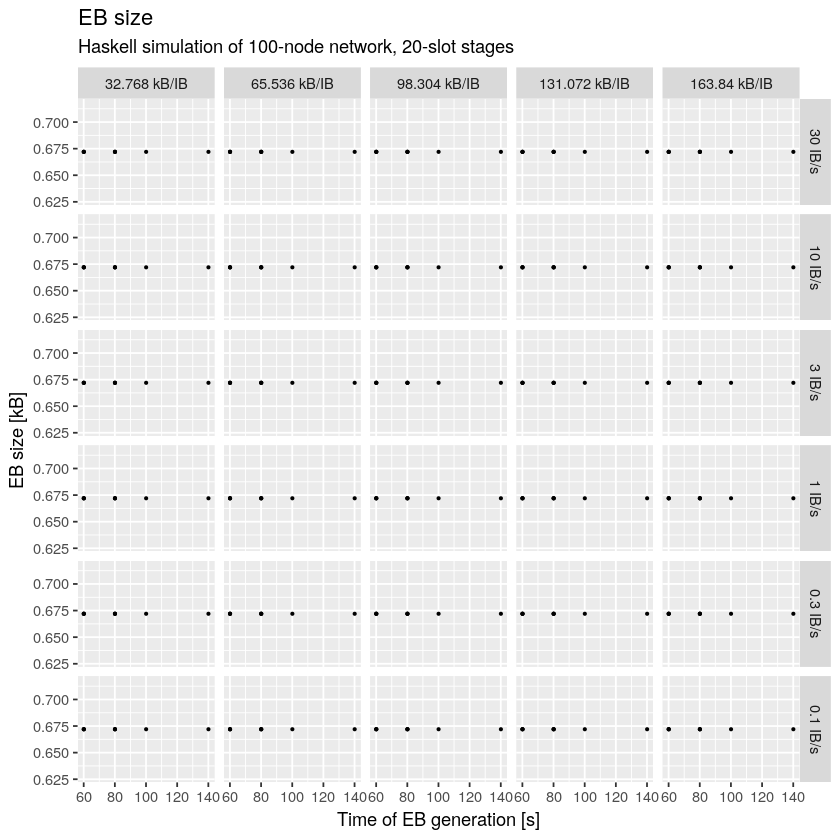

In [75]:
ggplot(
    ebgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that EB sizes are not modeled correctly by the Haskell simulation.

In [76]:
ggsave("plots/eb-size.svg", units="in", width=8, height=6, dpi=150)

In [77]:
ggsave("plots/eb-size.png", units="in", width=8, height=6, dpi=150)

## Ranking blocks

### Read results

In [78]:
rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w10", collection="rbgen")$find(), stringsAsFactors=TRUE)
rbgen %>% summary

   simulator        time             size         eb-count     
 haskell:540   Min.   : 47.09   Min.   :4941   Min.   :0.0000  
               1st Qu.: 65.09   1st Qu.:4941   1st Qu.:0.0000  
               Median : 81.09   Median :4941   Median :0.0000  
               Mean   : 88.04   Mean   :4941   Mean   :0.1667  
               3rd Qu.:111.09   3rd Qu.:4941   3rd Qu.:0.0000  
               Max.   :146.09   Max.   :4941   Max.   :1.0000  
                                                               
                    rb          label     network   ib-generation-probability
 -2950746169654411929: 90   default:540   100:540   Min.   : 0.1             
 -8062955889719650687: 60                           1st Qu.: 0.3             
 -9161735025789408340: 60                           Median : 2.0             
 1991976363184018089 : 60                           Mean   : 7.4             
 -3472384090249572538: 30                           3rd Qu.:10.0             
 -430707717064255397

In [79]:
fwrite(rbgen, "results/rbgen.csv")

### EB inclusion in RBs

#### Histogram

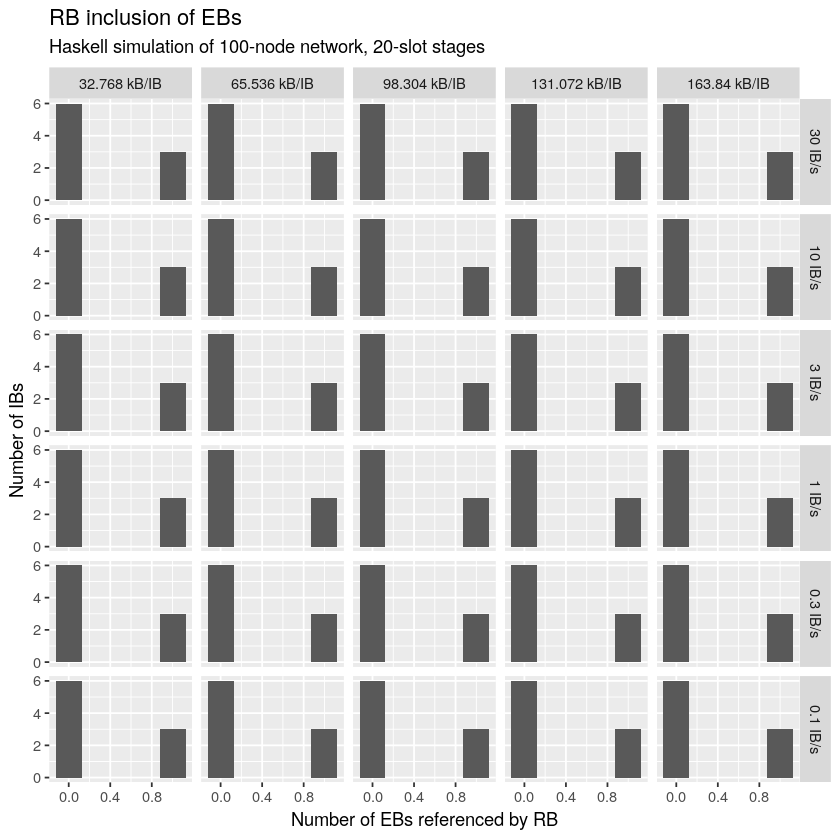

In [80]:
ggplot(
    rbgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("RB inclusion of EBs", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that RBs never reference more than on EB.

In [81]:
ggsave("plots/rb-referencing-histogram.svg", units="in", width=8, height=6, dpi=150)

In [82]:
ggsave("plots/rb-referencing-histogram.png", units="in", width=8, height=6, dpi=150)

#### Time series

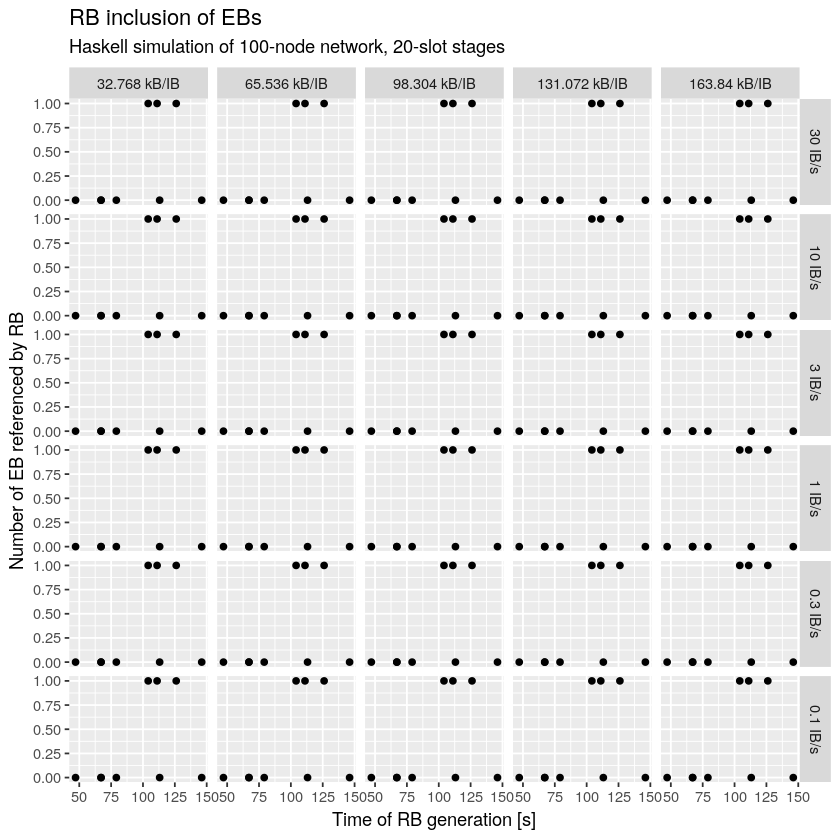

In [83]:
ggplot(
    rbgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that two EBs were waiting for RBs and were then referenced when those RBs were produced.

In [84]:
ggsave("plots/rb-referencing-timeseries.svg", units="in", width=8, height=6, dpi=150)

In [85]:
ggsave("plots/rb-referencing-timeseries.png", units="in", width=8, height=6, dpi=150)

### RB size

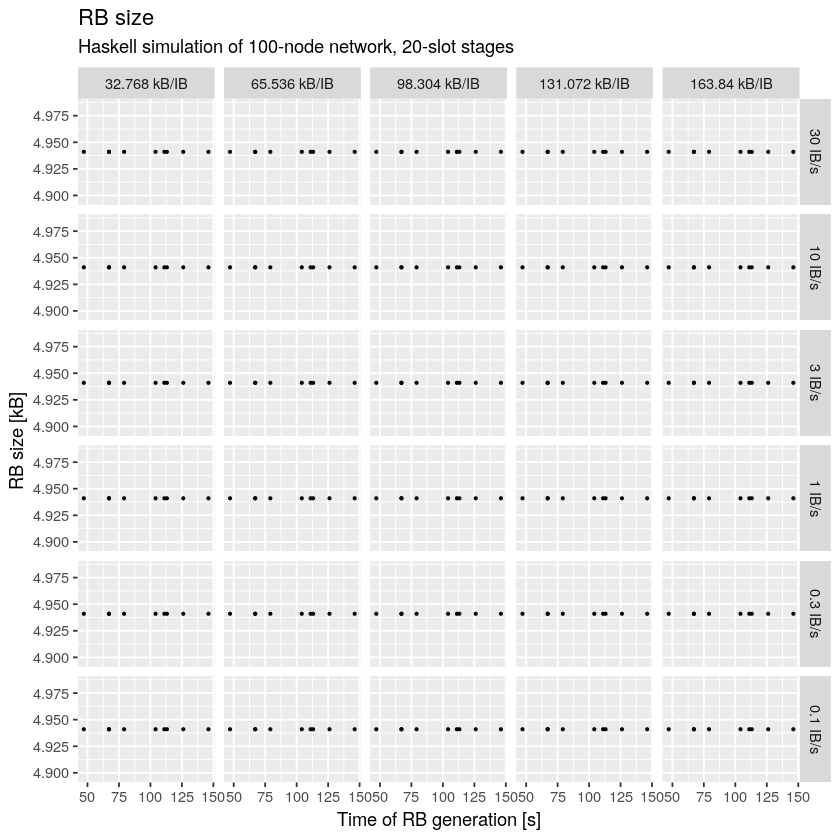

In [86]:
ggplot(
    rbgen[
        `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle="Haskell simulation of 100-node network, 20-slot stages")

In the plot above we see that the RB size is incorrect in that it does not vary according to whether a certificate was included or not.

In [87]:
ggsave("plots/rb-size.svg", units="in", width=8, height=6, dpi=150)

In [88]:
ggsave("plots/rb-size.png", units="in", width=8, height=6, dpi=150)